# Finetune Masked-AutoEncoder

- Finetune the deep network after pretraining the self-supervised learning framework.

-----

## Load Packages

In [1]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
%cd ..

D:\GitHub\eeg_analysis


In [2]:
# Load some packages
import os
import gc
from copy import deepcopy
import hydra
from omegaconf import OmegaConf
import wandb
import pprint
import numpy as np
import torch
from tqdm.auto import tqdm
from collections import OrderedDict
from cycler import cycler

import matplotlib
import matplotlib.pyplot as plt
import scienceplots

# custom package
from run_train import check_device_env
from run_train import set_seed
from run_train import compose_dataset
from run_train import generate_model
from train.ssl_train_script import ssl_train_script
from train.train_script import train_script
from models.utils import count_parameters

---

## Specify the dataset, model, and train setting

In [3]:
pre_model_path = 'local/checkpoint/'
pre_model_name = 'eg6s5fay'  # '5xlos421'
device = 'cuda:0'
ddp_size = 1

############
# Artifact #
############
art_config = dict()
art_config['project'] = 'caueeg-mae-artifact'
art_config['use_wandb'] = False
art_config['pre_model'] = pre_model_name
art_config['device'] = device
art_config['ddp_size'] = ddp_size

# art_config["art_filter_list"] = [9, 9, 9, 9, 9]
art_config["art_dropout"] = 0.1
art_config["art_use_age"] = "no"  # "conv", "embedding", "no"
art_config["art_out_activation"] = "softplus"  # "none", "relu", "softplus"  ######################################
art_config["art_loss_type"] = "mse"

art_config['total_samples'] = 1.0e+4
art_config['search_lr'] = False
art_config['base_lr'] = 1e-4
art_config['lr_scheduler_type'] = 'cosine_decay_with_warmup_half'

art_config["warmup_min"] = 150
art_config["num_history"] = 50
art_config['save_model'] = False

##################
# Classification #
##################
finetune_config = dict()
finetune_config['project'] = 'caueeg-mae-artifact-finetune'
finetune_config['use_wandb'] = False
finetune_config['pre_model'] = pre_model_name
finetune_config['device'] = device
finetune_config['ddp_size'] = ddp_size
finetune_config["task"] = "dementia"
finetune_config["out_dims"] = 3

# finetune_config["mask_ratio"] = 0.25
finetune_config["descending"] = False  #######################################################
finetune_config["global_pool"] = True
finetune_config["fc_stages"] = 2
finetune_config["dropout"] = 0.1
finetune_config["use_age"] = "conv"  ##################################################
# finetune_config["mixup"] = 0.3 ###
# finetune_config["crop_length"] = 8192*4  #############################################################
# finetune_config["criterion"] = "multi-bce"  # "cross-entropy", "multi-bce"

finetune_config["tuning_type"] = "finetune"  # "finetune", "fc_stage"
finetune_config["layer_wise_lr"] = True

finetune_config['total_samples'] = 256  ############################################################
# finetune_config['base_lr'] = 1e-3
finetune_config['search_lr'] = True
finetune_config['lr_search_steps'] = 100
finetune_config['lr_scheduler_type'] = 'cosine_decay_with_warmup_half'
finetune_config["warmup_min"] = 200
finetune_config["num_history"] = 5
finetune_config['save_model'] = False

In [4]:
print('PyTorch version:', torch.__version__)
device = torch.device(device if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available(): print('cuda is available.')
else: print('cuda is unavailable.')

PyTorch version: 2.1.2+cu118
cuda is available.


---
## Uncertainty Pretraining

In [5]:
# load pretrained configurations
path = os.path.join(pre_model_path, pre_model_name.split(',')[-1], 'checkpoint.pt')
try:
    ckpt = torch.load(path, map_location="cpu")
    config = ckpt['config']
except Exception as e:
    print(e)
    print(f'- checkpoint cannot be opened: {path}')
config["cwd"] = ""

pprint.pprint(config)

{'EKG': 'O',
 '_target_': 'models.ssl.mae_1d.mae_1d_pre_b_e768_d512',
 'activation': 'gelu',
 'age_mean': tensor([71.3079]),
 'age_std': tensor([9.6942]),
 'awgn': 0.003,
 'awgn_age': 0.001,
 'base_lr': 0.001,
 'class_label_to_name': ['Normal', 'Abnormal'],
 'class_name_to_label': {'Abnormal': 1, 'Normal': 0},
 'criterion': 'cross-entropy',
 'crop_length': 2560,
 'crop_multiple': 8,
 'crop_timing_analysis': False,
 'cwd': '',
 'dataset_name': 'CAUEEG dataset',
 'dataset_path': 'local/dataset/caueeg-dataset/',
 'ddp': False,
 'device': device(type='cuda'),
 'draw_result': True,
 'file_format': 'memmap',
 'in_channels': 20,
 'input_norm': 'datapoint',
 'iterations': 390625,
 'latency': 2000,
 'load_event': False,
 'lr_scheduler_type': 'cosine_decay_with_warmup_half',
 'mask_ratio': 0.75,
 'mgn': 0.003,
 'minibatch': 256,
 'minibatch_3090': 256,
 'mixed_precision': True,
 'mixup': 0.0,
 'model': '1D-MAE-B',
 'multi_batch_size': 32,
 'norm_pix_loss': True,
 'num_history': 500,
 'num_params

In [6]:
# update configuration
for k, v in art_config.items():
    config[k] = v

In [7]:
# load pretrained model
if not config.get("ddp", False):
    pre_model_state = ckpt["ssl_model_state"]
else:
    pre_model_state_ddp = deepcopy(ckpt["ssl_model_state"])
    pre_model_state = OrderedDict()
    for k, v in pre_model_state_ddp.items():
        name = k[7:]  # remove 'module.' of DataParallel/DistributedDataParallel
        pre_model_state[name] = v

In [8]:
config["ddp"] = False

# check the workstation environment and update some configurations
check_device_env(config)

# compose dataset
train_loader, val_loader, test_loader, multicrop_test_loader = compose_dataset(config)

pprint.pprint(config)

{'EKG': 'O',
 '_target_': 'models.ssl.mae_1d.mae_1d_pre_b_e768_d512',
 'activation': 'gelu',
 'age_mean': tensor([71.3079]),
 'age_std': tensor([9.6942]),
 'art_dropout': 0.1,
 'art_loss_type': 'mse',
 'art_out_activation': 'softplus',
 'art_use_age': 'no',
 'awgn': 0.003,
 'awgn_age': 0.001,
 'base_lr': 0.0001,
 'class_label_to_name': ['Normal', 'Abnormal'],
 'class_name_to_label': {'Abnormal': 1, 'Normal': 0},
 'criterion': 'cross-entropy',
 'crop_length': 2560,
 'crop_multiple': 8,
 'crop_timing_analysis': False,
 'cwd': '',
 'dataset_name': 'CAUEEG dataset',
 'dataset_path': 'local/dataset/caueeg-dataset/',
 'ddp': False,
 'ddp_size': 1,
 'device': device(type='cuda', index=0),
 'draw_result': True,
 'file_format': 'memmap',
 'in_channels': 20,
 'input_norm': 'datapoint',
 'iterations': 390625,
 'latency': 2000,
 'load_event': False,
 'lr_scheduler_type': 'cosine_decay_with_warmup_half',
 'mask_ratio': 0.75,
 'mgn': 0.003,
 'minibatch': 256,
 'minibatch_3090': 256,
 'mixed_precisio

In [9]:
# generate the model
config["_target_"] = config["_target_"].replace('pre', 'pre_art').replace('.mae_1d.', '.mae_1d_artifact.')
model = generate_model(config).to(device)

# load the model
model_state = model.state_dict()
for k, v in model_state.items():
    if not k.startswith('art') and not k.endswith("pos_embed"):
        model_state[k] = pre_model_state[k]

pre_model_state = deepcopy(model.state_dict())
model.load_state_dict(model_state)

<All keys matched successfully>

In [10]:
model.requires_grad_(False)
model = model.eval()

model.art_net.requires_grad_(True)
for k, v in model._parameters.items():
    if k.startswith("art"):
        v.requires_grad_(True)
model.art_net = model.art_net.train()

config["num_params"] = count_parameters(model)

# print(model)

In [11]:
for name, param in model.named_parameters():
    print(f"{name:100}\t|\t{param.requires_grad}")

class_token                                                                                         	|	False
enc_pos_embed                                                                                       	|	False
mask_token                                                                                          	|	False
dec_pos_embed                                                                                       	|	False
enc_proj.weight                                                                                     	|	False
enc_proj.bias                                                                                       	|	False
enc_blocks.encoder_layer_0.norm1.weight                                                             	|	False
enc_blocks.encoder_layer_0.norm1.bias                                                               	|	False
enc_blocks.encoder_layer_0.self_attention.in_proj_weight                                            	|	False
enc_blocks.encoder_

In [12]:
# collect some garbage
gc.collect()
torch.cuda.empty_cache()
torch.cuda.synchronize()

# fix the seed for reproducibility (a negative seed value means not fixing)
set_seed(config, rank=None)

# train
ssl_train_script(
    config,
    model,
    train_loader,
    config["preprocess_train"],
)

for k, v in model_state.items():
    pre_model_state[k] = model_state[k].to("cpu")


******************************    Configurations for Train    ******************************

{'EKG': 'O',
 '_target_': 'models.ssl.mae_1d_artifact.mae_1d_pre_art_b_e768_d512',
 'activation': 'gelu',
 'age_mean': tensor([71.3079]),
 'age_std': tensor([9.6942]),
 'art_dropout': 0.1,
 'art_loss_type': 'mse',
 'art_out_activation': 'softplus',
 'art_use_age': 'no',
 'awgn': 0.003,
 'awgn_age': 0.001,
 'base_lr': 0.0001,
 'class_label_to_name': ['Normal', 'Abnormal'],
 'class_name_to_label': {'Abnormal': 1, 'Normal': 0},
 'criterion': 'cross-entropy',
 'crop_length': 2560,
 'crop_multiple': 8,
 'crop_timing_analysis': False,
 'cwd': '',
 'dataset_name': 'CAUEEG dataset',
 'dataset_path': 'local/dataset/caueeg-dataset/',
 'ddp': False,
 'ddp_size': 1,
 'device': device(type='cuda', index=0),
 'draw_result': True,
 'file_format': 'memmap',
 'in_channels': 20,
 'input_norm': 'datapoint',
 'iterations': 390625,
 'latency': 2000,
 'load_event': False,
 'lr_scheduler_type': 'cosine_decay_with_w

---
## Visualize

In [13]:
del model, ckpt

gc.collect()
torch.cuda.empty_cache()
torch.cuda.synchronize()

---
## Finetuning

In [23]:
finetune_cycler = cycler(mask_ratio=[0.1])
finetune_cycler *= cycler(crop_length=[80]) + cycler(minibatch=[80])
finetune_cycler *= cycler(mixup=[0.1])
finetune_cycler *= cycler(seed=[0])
finetune_cycler *= cycler(art_patch_usage=[{"type": "softmax", "value": -1.0}])
for cyc in finetune_cycler:
    print(cyc)

{'mask_ratio': 0.1, 'crop_length': 80, 'minibatch': 80, 'mixup': 0.1, 'seed': 0, 'art_patch_usage': {'type': 'softmax', 'value': -1.0}}



******************************    Configurations for Train    ******************************

{'EKG': 'O',
 '_target_': 'models.mae_1d_artifact.mae_1d_art_b_e768_d512',
 'activation': 'gelu',
 'age_mean': tensor([71.3079]),
 'age_std': tensor([9.6942]),
 'art_dropout': 0.1,
 'art_loss_type': 'mse',
 'art_out_activation': 'softplus',
 'art_patch_usage': {'type': 'softmax', 'value': -1.0},
 'art_use_age': 'no',
 'awgn': 0.003,
 'awgn_age': 0.001,
 'base_lr': 0.0015773933612004821,
 'class_label_to_name': ['Normal', 'MCI', 'Dementia'],
 'class_name_to_label': {'Dementia': 2, 'MCI': 1, 'Normal': 0},
 'criterion': 'cross-entropy',
 'crop_length': 80,
 'crop_multiple': 8,
 'crop_timing_analysis': False,
 'cwd': '',
 'dataset_name': 'CAUEEG dataset',
 'dataset_path': 'local/dataset/caueeg-dataset/',
 'ddp': False,
 'ddp_size': 1,
 'descending': False,
 'device': device(type='cuda', index=0),
 'draw_result': True,
 'dropout': 0.1,
 'fc_stages': 2,
 'file_format': 'memmap',
 'global_pool': Tru

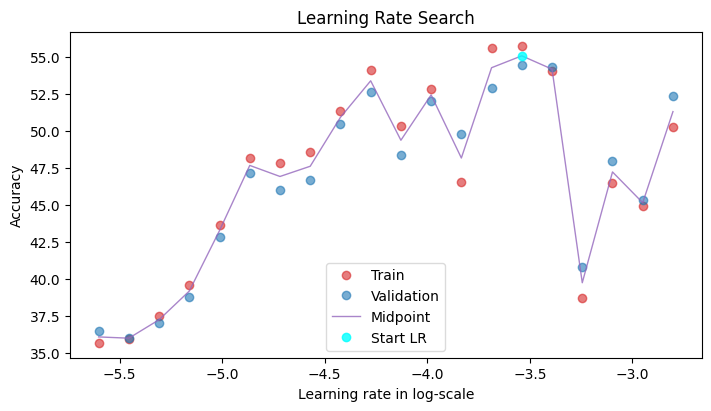

       1 /        3 iter - Loss: 1.5463, Train Acc.: 30.0003, Val. Acc.: 26.8627
       2 /        3 iter - Loss: 1.2382, Train Acc.: 38.7500, Val. Acc.: 27.1499
       3 /        3 iter - Loss: 1.3945, Train Acc.: 32.5000, Val. Acc.: 27.2829


In [ ]:
for cyc in finetune_cycler:
    # update configuration
    for k, v in finetune_config.items():
        config[k] = v
    for k, v in cyc.items():
        config[k] = v
    config["ddp"] = False

    # check the workstation environment and update some configurations
    check_device_env(config)
    
    # compose dataset
    train_loader, val_loader, test_loader, multicrop_test_loader = compose_dataset(config)
    # pprint.pprint(config)

    # generate the model
    config["_target_"] = config["_target_"].replace('.ssl', '').replace('_pre', '')
    model = generate_model(config).to(device)
    
    # load the model
    model_state = model.state_dict()
    for k, v in model_state.items():
        if not k.startswith("fc") and not k.endswith("pos_embed"):
            model_state[k] = pre_model_state[k]
    
    model.load_state_dict(model_state)
    model.finetune_mode(config["tuning_type"])
    config["num_params"] = count_parameters(model)
    
    # for name, param in model.named_parameters():
    #     print(f"{name:100}\t|\t{param.requires_grad}")

    # collect some garbage
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    
    # fix the seed for reproducibility (a negative seed value means not fixing)
    set_seed(config, rank=None)
    
    # train
    train_script(
        config,
        model,
        train_loader,
        val_loader,
        test_loader,
        multicrop_test_loader,
        config["preprocess_train"],
        config["preprocess_test"],
    )

print("- END -")